<div align="right"><h8><i>Cristina Cristalli - 838022<br>
Francesca Franzese - 847780<br>
    Alessia Petescia - 839141</i><br><br>
    <b>Progetto Digital Signal and Image Management - Punto 2<br>
        CdL Data Science 2020</b></h8></div>

<h2>2. Processing di segnali bi-dimensionali</h2>

<b>Task:</b> Riconoscere l'identità dei membri del gruppo a partire da una foto del volto.
<br><br>Le foto dei membri del gruppo sono state scattate con <b><i> posizione, espressione e illuminazione variabile</i></b>. In totale, sono state acquisite 2050 immagini.
Queste sono state poi ottimizzate per il task attraverso l'applicazione di un face detector implementato con OpenCV.
<p>Il notebook è strutturato come segue:</p>
<ol>
<li><i>Caricamento delle immagini e applicazione del face detector</i></li><br>
<li><i>Estrazione delle features convoluzionali attraverso modelli pre-allenati</i>: 
<ul style="list-style-type:square">
<li>VGG16</li>
<li>Densenet121</li>
</ul><br>
</li>
<li><i>Addestramento dei modelli di classificazione sulle features estratte: </i> gli iperparametri dei modelli sono stati scelti utilizzando le tecniche del Grid Search e del Random search.
I modelli implementati sono:
<ul style="list-style-type:square">
<li>Logistic regression</li>
<li>Random Forest</li>
<li>Neural Network</li>
</ul>
</li>
</ol>

In [1]:
import os
import numpy as np
from numpy import expand_dims
from numpy import asarray
import pandas as pd
import cv2
import random
import PIL
from PIL import Image
from os import listdir
from matplotlib import image
from matplotlib import pyplot as plt
import seaborn as sns

import mtcnn
from mtcnn.mtcnn import MTCNN

# Importing sklearn libraries
from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
 
# Importing Keras libraries
import keras
from keras.utils import np_utils
from keras.models import Sequential , Model
from tensorflow.keras.applications import VGG16, DenseNet121
from keras.applications import imagenet_utils
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import load_img,img_to_array
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, GlobalAveragePooling2D , Input, ReLU, Softmax
from keras_vggface.vggface import VGGFace
from keras.applications.vgg16 import preprocess_input
from keras.applications.densenet import preprocess_input as preprocess_input_ds
from keras.engine import  Model
from keras.layers import Input
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from keras.wrappers.scikit_learn import KerasClassifier 

import tensorflow
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers

Using TensorFlow backend.


In [2]:
import warnings
warnings.filterwarnings('ignore')

<h2>Face Detector</h2>

In [3]:
detector = MTCNN()

In [4]:
def face_detector(id_persona, train):
    fotoscartate = 0
    nr=0

    for elem in train:
        required_size=(224, 224)
        pixels = cv2.imread(train[nr])
        results = detector.detect_faces(pixels)

        if not results or results[0]==False:
            nr=nr+1
            fotoscartate = fotoscartate + 1
            continue

        # estrazione della bounding box
        x1, y1, width, height = results[0]['box']
        x2, y2 = x1 + width, y1 + height

        # estrazione della faccia
        face = pixels[y1:y2, x1:x2]

        if face.any()==[] or face.any()==False:
            nr=nr+1
            fotoscartate = fotoscartate + 1
            continue

        # resize dei pixels alla size standard
        image = Image.fromarray(face)
        image = image.resize(required_size)
        
        # conversione dell'immagine in un array
        face_array = asarray(image)    
        
        # Salvataggio delle foto in una cartella in locale, così da permettere il reload più veloce
        directory='C:/Users/Francesca Franzese/Desktop/Digital Signal and Image Management/Progetto/foto_detected'
        os.chdir(directory)
        cv2.imwrite(id_persona + str(nr) + '.jpg', face_array)

        nr=nr+1

    return fotoscartate

In [5]:
#face detector per le foto di Alessia
alessia_train = []

for elem in listdir('C:/Users/Francesca Franzese/Desktop/Digital Signal and Image Management/Progetto/foto_ale'):
    alessia_train.append('C:/Users/Francesca Franzese/Desktop/Digital Signal and Image Management/Progetto/foto_ale/' + elem)

print("# foto iniziali: " + str(len(alessia_train)))
    
fotoscartate = face_detector("0_", alessia_train)
print("# foto scartate: " + str(fotoscartate))

print("# foto totali Alessia: " + str(len(alessia_train) - fotoscartate) )

# foto iniziali: 675
# foto scartate: 62
# foto totali Alessia: 613


In [6]:
#face detector per le foto di Cristina
cristina_train = []

for elem in listdir('C:/Users/Francesca Franzese/Desktop/Digital Signal and Image Management/Progetto/foto_cri'):
    cristina_train.append('C:/Users/Francesca Franzese/Desktop/Digital Signal and Image Management/Progetto/foto_cri/' + elem)

print("# foto iniziali: " + str(len(cristina_train)))

fotoscartate = face_detector("1_", cristina_train)
print("# foto scartate: " + str(fotoscartate))

print("# foto totali Cristina: " + str(len(cristina_train) - fotoscartate) )

# foto iniziali: 697
# foto scartate: 2
# foto totali Cristina: 695


In [7]:
#face detector per le foto di Francesca
francesca_train = []

for elem in listdir('C:/Users/Francesca Franzese/Desktop/Digital Signal and Image Management/Progetto/foto_fra'):
    francesca_train.append('C:/Users/Francesca Franzese/Desktop/Digital Signal and Image Management/Progetto/foto_fra/' + elem)

print("# foto iniziali: " + str(len(francesca_train)))

fotoscartate = face_detector("2_", francesca_train)
print("# foto scartate: " + str(fotoscartate))

print("# foto totali Francesca: " + str(len(francesca_train) - fotoscartate) )

# foto iniziali: 678
# foto scartate: 11
# foto totali Francesca: 667


<h2>Caricamento immagini</h2>

In [8]:
#Caricamento immagini da locale, già passate nel face detector

#carico dataset
db_immagini = []
# variabile 
y=[]

#caricamento
for filename in listdir('C:/Users/Francesca Franzese/Desktop/Digital Signal and Image Management/Progetto/foto_detected'):
    img_data = cv2.imread('C:/Users/Francesca Franzese/Desktop/Digital Signal and Image Management/Progetto/foto_detected/' + filename)
    img_data = cv2.resize(img_data,(224, 224))
    img_data = np.asarray(img_data)
    db_immagini.append([img_data])
    y.append(list(filename)[0])

In [9]:
len(db_immagini)

1975

In [10]:
np.shape(db_immagini[1])

(1, 224, 224, 3)

In [11]:
# reshape
db_immagini=np.array(db_immagini).reshape(-1,224, 224,3)

In [12]:
np.shape(db_immagini[1])

(224, 224, 3)

<h2>Classificazione</h2>

<h2>VGGFace</h2>

In [13]:
# preprocessing delle immagini per la VGG
db_immagini_vgg = preprocess_input(db_immagini)

In [14]:
# divisione in train e test
db_immagini_vgg, y = shuffle(db_immagini_vgg, y)
X_train, X_test, y_train, y_test = train_test_split(db_immagini_vgg, y, test_size=0.3)

In [15]:
X_train = X_train.astype('float32')/255.0
X_test = X_test.astype('float32')/255.0

In [16]:
# utilizzo del modello VGGFace per l'estrazione delle features convoluzionali 
vgg_features = VGGFace(include_top=False, input_shape=(224, 224, 3), pooling='avg')

X_train_embedding = vgg_features.predict(X_train)
X_test_embedding = vgg_features.predict(X_test)

<h4>Regressione Logistica</h4>

In [17]:
# Parametri da provare in cross validation
param_grid= [{'solver': ['newton-cg', 'lbfgs','sag', 'saga']}]
    
clf_lr = GridSearchCV(LogisticRegression(random_state=0), param_grid, scoring='accuracy')

clf_lr.fit(X_train_embedding, y_train)

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=0, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'solver': ['newton-cg', 'lbfgs', 'sag', 'saga']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [18]:
print("Migliore combinazione di parametri:")
print(" solver: "+str(clf_lr.best_estimator_.solver))

Migliore combinazione di parametri:
 solver: newton-cg


In [20]:
clf_lr_pred=clf_lr.predict(X_test_embedding)

In [21]:
print(classification_report(y_test, clf_lr_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       188
           1       1.00      1.00      1.00       216
           2       1.00      0.99      1.00       189

   micro avg       1.00      1.00      1.00       593
   macro avg       1.00      1.00      1.00       593
weighted avg       1.00      1.00      1.00       593



[[188   0   0]
 [  0 216   0]
 [  1   0 188]]


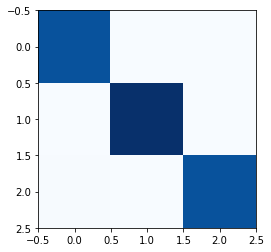

In [22]:
cm = confusion_matrix(y_test, clf_lr_pred)   
print(cm)
plt.imshow(cm, cmap=plt.cm.Blues)

In [23]:
print(accuracy_score(y_test, clf_lr_pred))

0.9983136593591906


<h4>Random Forest</h4>

In [24]:
# Parametri da provare in cross validation
param_grid_rf = {'n_estimators': [1, 4, 8, 12, 16, 20],
                 'criterion': ['entropy', 'gini'], }

clf_rf = GridSearchCV(RandomForestClassifier(),param_grid_rf)

clf_rf = clf_rf.fit(X_train_embedding, y_train)

In [25]:
# Risultato della cross validation per la selezione dei parametri
print("Migliore combinazione di parametri:")
print(" n_estimators: "+str(clf_rf.best_estimator_.n_estimators))
print(" criterion: "+str(clf_rf.best_estimator_.criterion))

Migliore combinazione di parametri:
 n_estimators: 20
 criterion: gini


In [26]:
clf_rf_pred = clf_rf.predict(X_test_embedding) 

In [27]:
print(classification_report(y_test, clf_rf_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       188
           1       1.00      1.00      1.00       216
           2       1.00      0.99      1.00       189

   micro avg       1.00      1.00      1.00       593
   macro avg       1.00      1.00      1.00       593
weighted avg       1.00      1.00      1.00       593



[[188   0   0]
 [  1 215   0]
 [  1   0 188]]


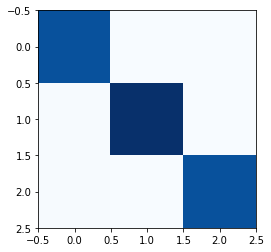

In [28]:
cm = confusion_matrix(y_test, clf_rf_pred)   
print(cm)
plt.imshow(cm, cmap=plt.cm.Blues)

In [29]:
print(accuracy_score(y_test, clf_rf_pred))

0.9966273187183811


<h4>Neural Network</h4>

In [30]:
np.shape(X_train_embedding)

(1382, 512)

In [58]:
def NN_model(optimizer='adam', activation_layer_1 ='softmax',activation_layer_2 ='softmax', activation_last_layer = 'softmax',  neurons = 1, dropout_rate_1 = 0.0, dropout_rate_2 = 0.0, dropout_rate_3 = 0.0):

    modello= Sequential()
    modello.add(Dense(neurons, activation='relu', input_shape=(512,)))
    #modello.add(Flatten())
    modello.add(Dropout(dropout_rate_1))
    modello.add(Dense(neurons, activation=activation_layer_1))
    modello.add(Dropout(dropout_rate_2))
    modello.add(Dense(neurons, activation=activation_layer_2))
    modello.add(Dropout(dropout_rate_3))
    modello.add(Dense(3, activation = activation_last_layer))
    modello.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy',metrics=['accuracy'])
    
    return(modello)

In [ ]:
modello_per_grid_search = KerasClassifier(build_fn=NN_model, verbose = 0)
batch_size = [150, 200]
epochs = [3,5]
optimizer = ['Adadelta', 'Adam']
activation_layer_1 = ['softmax','relu']
activation_layer_2 = ['softmax','relu']
activation_last_layer = ['softmax','relu']
neurons = [512,1024]
dropout_rate_1 = [0.0, 0.5]
dropout_rate_2 = [0.0, 0.5]
dropout_rate_3 = [0.0, 0.5]
param_grid = dict(batch_size=batch_size, epochs=epochs,optimizer = optimizer,
                           dropout_rate_1 = dropout_rate_1,
                           dropout_rate_2 = dropout_rate_2,
                           dropout_rate_3 = dropout_rate_3,
                           activation_layer_1=activation_layer_1, 
                           activation_layer_2=activation_layer_2,
                           neurons = neurons,
                           activation_last_layer = activation_last_layer)

grid_search_nn = GridSearchCV(estimator=modello_per_grid_search, param_grid=param_grid, cv=2)
network_history = grid_search_nn.fit(X_train_embedding, y_train)

In [ ]:
network_history.best_params_

In [ ]:
predictions = network_history.predict(X_test_embedding)

In [ ]:
cm = confusion_matrix(y_test, predictions)
print(cm)
plt.imshow(cm, cmap=plt.cm.Blues)

In [ ]:
print(accuracy_score(y_test, predictions))

<h2>DenseNet121</h2>

In [ ]:
# preprocessing delle immagini per la VGG
db_immagini_ds = preprocess_input_ds(db_immagini)

In [ ]:
# divisione in train e test
db_immagini_ds, y = shuffle(db_immagini_ds, y)
X_train_ds, X_test_ds, y_train_ds, y_test_ds = train_test_split(db_immagini_ds, y, test_size=0.3)

In [ ]:
X_train_ds = X_train_ds.astype('float32')/255.0
X_test_ds = X_test_ds.astype('float32')/255.0

In [ ]:
# utilizzo del modello DenseNet121 per l'estrazione delle features convoluzionali
ds_features = DenseNet121(include_top=False, input_shape=(224, 224, 3), pooling='avg')

X_train_embedding_ds = ds_features.predict(X_train_ds)
X_test_embedding_ds = ds_features.predict(X_test_ds)

<h4>Regressione Logistica</h4>

In [ ]:
# Parametri da provare in cross validation
param_grid= [{'solver': ['newton-cg', 'lbfgs','sag', 'saga']}]
    
clf_lr_ds = GridSearchCV(LogisticRegression(random_state=0), param_grid, scoring='accuracy')
clf_lr_ds.fit(X_train_embedding_ds, y_train_ds)

In [ ]:
print("Migliore combinazione di parametri:")
print(" solver: "+str(clf_lr_ds.best_estimator_.solver))

In [ ]:
clf_lr_ds_pred=clf_lr_ds.predict(X_test_embedding_ds)

In [ ]:
print(classification_report(y_test_ds, clf_lr_ds_pred))

In [ ]:
cm = confusion_matrix(y_test_ds, clf_lr_ds_pred)   
print(cm)
plt.imshow(cm, cmap=plt.cm.Blues)

In [ ]:
print(accuracy_score(y_test_ds, clf_lr_ds_pred))